# Pricing Optimization (Price Elasticity of Demand)
[![demand_elasticity.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Demand_elasticity/demand_elasticity.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Demand_elasticity/demand_elasticity.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Demand_elasticity/demand_elasticity.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Demand_elasticity/demand_elasticity.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Demand_elasticity/demand_elasticity.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Demand_elasticity/demand_elasticity.ipynb)](https://colab.ampl.com)

This model finds the point that maximizes profit based on price elasticity and cost.

[*Partner with the AMPL team to transform complex problems into optimized solutions. AMPL consulting services combine deep technical knowledge with industry-leading insights, helping you unlock the full potential of optimization within your organization.*](https://ampl.com/services/)

Tags: amplpy, MIP, pricing-optimization, demand-elasticity, profit-maximization, economic-modeling, piecewise-linear, cplex

Notebook author: Mikhail Riabtsev <<mail@solverytic.com>>
***

# 1. Model Description

This notebook describes 3 piecewise linear approaches to dealing with nonlinear dependencies and designed to optimize profit through optimal point or price-step selection based on demand and price parameters. Each approach employs unique strategies to achieve its objectives while adhering to specific constraints.

## Key Components

### Price-Demand Elastisity Function

![Price_Demand_Elastisity](https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/mikhail/Demand_elasticity/Price_Demand_Elastisity.jpg)

### General Parameters
- **Demand and Price**: Represent demand and price at each point or step, respectively.
- **Cost**: Unit cost (2 $ per unit).

### Objective: 
It is necessary to determine the optimal level of sales price in order to obtain maximum profit:

  $\text{Maximize TotalProfit } = \sum_{𝑝 \in POINTS}(price[𝑝] − cost[p]) × demand[𝑝])$

  To linearize the existing elasticity of demand function from price changes, we need to select nodal points. The number of selected points and their location on the curve can be any.
  For the purposes of our project, we will use the following corner points:
  $[(1, 10), (3, 7), (5, 5), (7, 4), (9, 3.8), (11, 4), (13, 3), (15, 1), (17, 0.5), (19, 0)]$

![Price_Demand_Elastisity_2](https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/mikhail/Demand_elasticity/Price_Demand_Elastisity_2.jpg)  

# 2. Download Necessary Extensions and Libraries

In [ ]:
# Install dependencies
%pip install -q amplpy pandas numpy matplotlib scipy
import pandas as pd  # Loading panda to work with pandas.DataFrame objects (https://pandas.pydata.org/)
import numpy as np  # Loading numpy to perform multidimensional calculations numpy.matrix (https://numpy.org/)

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc", "highs", "gurobi", "cplex"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
from amplpy import AMPL

ampl = AMPL()  # create a new AMPL object with all default settings

# 3. Approach#1 (Optimal nodal point)
This approach determines the nodal point with maximum profit.

![Price_Demand_Elastisity_4](https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/mikhail/Demand_elasticity/Price_Demand_Elastisity_4.jpg)  

## 3.1. AMPL Model Formulation


In [4]:
%%writefile demand_elasticity__model.mod
reset;
# Model Name: Pricing Optimization (Price Elasticity of Demand)
# Purpose: Select one point from a set of price level and demand to maximize total profit
# Version: 1.0
# Last Updated: Jan 2025


### SETS & PARAMETERS
# Input parameters defining total quantity, cost, price steps, and demand
param unit_cost >= 0;                   # Unit cost of the product
param n_step integer > 0;               # Number of steps in the piecewise linear price function
param demand {1..n_step} >= 0;          # Demand values at each price step
param price {1..n_step} >= 0;           # Price values for each demand step

### VARIABLES
# Define decision variables for point selection
var IsSelect {1..n_step} binary;        # Binary decision variable: 1 if point is selected, 0 otherwise

### OBJECTIVE
# Maximize total profit based on selected point
maximize TotalProfit:
    sum {p in 1..n_step} demand[p] * (price[p] - unit_cost) * IsSelect[p];

### CONSTRAINTS
# Ensure exactly one point is selected
subject to OnePriceSelected:
    sum {p in 1..n_step} IsSelect[p] = 1;   # Exactly one point is selected

Overwriting demand_elasticity__model.mod


## 3.2. Load data

In [5]:
from scipy.interpolate import interp1d

ampl.read("demand_elasticity__model.mod")  # Load the AMPL model from the file

# Data for demand and price
data = [
    (1, 10),
    (3, 7),
    (5, 5),
    (7, 4),
    (9, 3.8),
    (11, 4),
    (13, 3),
    (15, 1),
    (17, 0.5),
    (19, 0),
]

ampl.param["unit_cost"] = 2  # Unit cost of the product
ampl.param["n_step"] = len(data)  # Number of discrete steps in the data

demand_param = ampl.getParameter("demand")  # Get the 'demand' parameter
price_param = ampl.getParameter("price")  # Get the 'price' parameter
for i, (demand_value, price_value) in enumerate(
    data, start=1
):  # Loop through data points
    demand_param.set(i, demand_value)  # Assign demand value to each step
    price_param.set(i, price_value)  # Assign price value to each step

## 3.3. Solve problem

In [ ]:
# Set the solver type for use in solving the problems
solver = "cplex"  # Use CBC solver for optimization tasks

ampl.option["show_stats"] = 0  # Show problem size statistics (default: 0)
ampl.option["display_1col"] = 0  # Disable single-column data display
# ampl.option['omit_zero_rows'] = 1 # Hide rows with zero values
# ampl.option['omit_zero_cols'] = 1 # Hide columns with zero values
ampl.option["mp_options"] = (
    "outlev=1 lim:time=20"  # Configure CBC options (output level and time limit)
)

ampl.solve(
    solver=solver, verbose=False
)  # Solve the optimization problem using CBC solver

## 3.4. Display results

In [7]:
# Display results for key variables
ampl.display("_varname", "_var", "_var.lb", "_var.ub", "_var.rc", "_var.slack")
ampl.display("_conname", "_con", "_con.body", "_con.lb", "_con.ub", "_con.slack")
ampl.display("_objname", "_obj")

:       _varname    _var _var.lb _var.ub _var.rc _var.slack    :=
1    'IsSelect[1]'    0      0       1       8        0
2    'IsSelect[2]'    0      0       1      15        0
3    'IsSelect[3]'    0      0       1      15        0
4    'IsSelect[4]'    0      0       1      14        0
5    'IsSelect[5]'    0      0       1      16.2      0
6    'IsSelect[6]'    1      0       1      22        0
7    'IsSelect[7]'    0      0       1      13        0
8    'IsSelect[8]'    0      0       1     -15        0
9    'IsSelect[9]'    0      0       1     -25.5      0
10   'IsSelect[10]'   0      0       1     -38        0
;

:       _conname     _con _con.body _con.lb _con.ub _con.slack    :=
1   OnePriceSelected   0       1        1       1        0
;

:    _objname   _obj    :=
1   TotalProfit   22
;



# 4. Approach#2 (Maximum demand for optimal price)
Ultimately, this approach determines the maximum demand for a given price level by the key points.

![Price_Demand_Elastisity_3](https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/mikhail/Demand_elasticity/Price_Demand_Elastisity_3.jpg)  

## 4.1. AMPL Model Formulation

In [8]:
%%writefile demand_elasticity_1_model.mod
reset;

# Model Name: # Pricing Optimization
# Description: This model maximizes total revenue by selecting the optimal price step and managing quantity sold under piecewise linear pricing.
# Version: 1.0
# Last Updated: Jan 2025

### PARAMETERS
# Input parameters defining total quantity, cost, price steps, and demand
param unit_cost >= 0;                   # Unit cost of the product
param n_step integer > 0;               # Number of steps in the piecewise linear price function
param demand {1..n_step+1} >= 0;        # Demand values at each price step
param price {1..n_step+1} >= 0;         # Price values for each demand step

### VARIABLES
# Decision variables for managing quantity and selecting price steps
var IsSelect {1..n_step} binary;        # Binary decision variable: 1 if point is selected, 0 otherwise
var Quantity_Sold {1..n_step} >= 0, integer; # Quantity sold at each price step

### OBJECTIVE
maximize Total_Profit:                  # Maximize total revenue from sales while considering costs and constraints
    sum{i in 1..n_step} Quantity_Sold[i] * (price[i] - unit_cost); 

### CONSTRAINTS
# Ensure logical and physical constraints are met
s.t. OnePriceSelected:                  # Only one price step can be selected
    sum {i in 1..n_step} IsSelect[i] = 1;

s.t. Demand_Upper_Bound {i in 1..n_step-1}:# Quantity sold must align with selected price step
    Quantity_Sold[i] <= (demand[i+1] - 0.0001)  * IsSelect[i] ;

Overwriting demand_elasticity_1_model.mod


## 4.2. Load data

In [9]:
ampl.read("demand_elasticity_1_model.mod")  # Load the AMPL model from the file

# Data for demand and price
data = [
    (1, 10),
    (3, 7),
    (5, 5),
    (7, 4),
    (9, 3.8),
    (11, 4),
    (13, 3),
    (15, 1),
    (17, 0.5),
    (19, 0),
]

ampl.param["unit_cost"] = 2  # Unit cost of the product
ampl.param["n_step"] = len(data) - 1  # Number of discrete steps in the data

demand_param = ampl.getParameter("demand")  # Get the 'demand' parameter
price_param = ampl.getParameter("price")  # Get the 'price' parameter
for i, (demand_value, price_value) in enumerate(
    data, start=1
):  # Loop through data points
    demand_param.set(i, demand_value)  # Assign demand value to each step
    price_param.set(i, price_value)  # Assign price value to each step

## 4.3. Solve problem

In [ ]:
# Set the solver type for use in solving the problems
solver = "cplex"  # Use CBC solver for optimization tasks

ampl.option["show_stats"] = 0  # Show problem size statistics (default: 0)
ampl.option["display_1col"] = 0  # Disable single-column data display
# ampl.option['omit_zero_rows'] = 1 # Hide rows with zero values
# ampl.option['omit_zero_cols'] = 1 # Hide columns with zero values
ampl.option["mp_options"] = (
    "outlev=1 lim:time=20"  # Configure CBC options (output level and time limit)
)

ampl.solve(
    solver=solver, verbose=False
)  # Solve the optimization problem using CBC solver

## 4.4. Display results

In [11]:
# Display results for key variables
ampl.display("_varname", "_var", "_var.lb", "_var.ub", "_var.rc", "_var.slack")
ampl.display("_conname", "_con", "_con.body", "_con.lb", "_con.ub", "_con.slack")
ampl.display("_objname", "_obj")

:         _varname      _var _var.lb   _var.ub  _var.rc _var.slack    :=
1    'IsSelect[1]'         0     0            1    0         0
2    'IsSelect[2]'         0     0            1    0         0
3    'IsSelect[3]'         0     0            1    0         0
4    'IsSelect[4]'         0     0            1    0         0
5    'IsSelect[5]'         0     0            1    0         0
6    'IsSelect[6]'         1     0            1    0         0
7    'IsSelect[7]'         0     0            1    0         0
8    'IsSelect[8]'         0     0            1    0         0
9    'IsSelect[9]'         0     0            1    0         0
10   'Quantity_Sold[1]'    0     0            2    8         0
11   'Quantity_Sold[2]'    0     0            4    5         0
12   'Quantity_Sold[3]'    0     0            6    3         0
13   'Quantity_Sold[4]'    0     0            8    2         0
14   'Quantity_Sold[5]'    0     0           10    1.8       0
15   'Quantity_Sold[6]'   12     0           

# 5. Approach#3 (Using the built-in AMPL piecewise linear function)

![Price_Demand_Elastisity_3](https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/mikhail/Demand_elasticity/Price_Demand_Elastisity_3.jpg)  

## 5.1. AMPL Model Formulation

In [12]:
%%writefile demand_elasticity_2_model.mod
reset;

# Model Name: Pricing Optimization (AMPL Piecewise construction for Price Elasticity of Demand)
# Version: 1.0
# Last Updated: Jan 2025

### PARAMETERS
# Input parameters defining total quantity, cost, price steps, and demand
param unit_cost >= 0;                   # Unit cost of the product
param n_step integer > 0;               # Number of steps in the piecewise linear price function
param demand {1..n_step+1} >= 0;        # Demand values at each price step
param price {1..n_step+1} >= 0;         # Price values for each demand step

### VARIABLES
# Decision variables for managing quantity and selecting price steps
var IsSelect {1..n_step} binary;        # Binary decision variable: 1 if point is selected, 0 otherwise
var Quantity_Sold {1..n_step} >= 0, integer; # Quantity sold at each price step

### OBJECTIVE
maximize Total_Profit:                  # Maximize total revenue from sales while considering costs and constraints
    sum {i in 1..n_step} 
    <<demand[i]; {p in i..i+1} (price[p]- unit_cost)>> Quantity_Sold[i];
 # Find more information about the piecewise linear function:  https://ampl.com/wp-content/uploads/Chapter-17-Piecewise-Linear-Programs-AMPL-Book.pdf

### CONSTRAINTS
# Ensure logical and physical constraints are met
s.t. OnePriceSelected:                  # Only one price step can be selected
    sum {i in 1..n_step} IsSelect[i] = 1;

s.t. Demand_Upper_Bound {i in 1..n_step-1}:# Quantity sold must align with selected price step
    Quantity_Sold[i] <= (demand[i+1] - 0.0001)  * IsSelect[i] ;

Overwriting demand_elasticity_2_model.mod


## 5.2. Load data

In [13]:
ampl.read("demand_elasticity_2_model.mod")  # Load the AMPL model from the file

# Data for demand and price
data = [
    (1, 10),
    (3, 7),
    (5, 5),
    (7, 4),
    (9, 3.8),
    (11, 4),
    (13, 3),
    (15, 1),
    (17, 0.5),
    (19, 0),
]

ampl.param["unit_cost"] = 2  # Unit cost of the product
ampl.param["n_step"] = len(data) - 1  # Number of discrete steps in the data

demand_param = ampl.getParameter("demand")  # Get the 'demand' parameter
price_param = ampl.getParameter("price")  # Get the 'price' parameter
for i, (demand_value, price_value) in enumerate(
    data, start=1
):  # Loop through data points
    demand_param.set(i, demand_value)  # Assign demand value to each step
    price_param.set(i, price_value)  # Assign price value to each step

## 5.3. Solve problem

In [ ]:
# Set the solver type for use in solving the problems
solver = "cplex"  # Use CBC solver for optimization tasks

ampl.option["show_stats"] = 0  # Show problem size statistics (default: 0)
ampl.option["display_1col"] = 0  # Disable single-column data display
# ampl.option['omit_zero_rows'] = 1 # Hide rows with zero values
# ampl.option['omit_zero_cols'] = 1 # Hide columns with zero values
ampl.option["mp_options"] = (
    "outlev=1 lim:time=20"  # Configure CBC options (output level and time limit)
)

ampl.solve(
    solver=solver, verbose=False
)  # Solve the optimization problem using CBC solver

## 5.4. Display results

In [15]:
# Display results for key variables
ampl.display("_varname", "_var", "_var.lb", "_var.ub", "_var.rc", "_var.slack")
ampl.display("_conname", "_con", "_con.body", "_con.lb", "_con.ub", "_con.slack")
ampl.display("_objname", "_obj")

:         _varname      _var _var.lb   _var.ub  _var.rc _var.slack    :=
1    'IsSelect[1]'         0     0            1    0         0
2    'IsSelect[2]'         0     0            1    0         0
3    'IsSelect[3]'         0     0            1    0         0
4    'IsSelect[4]'         0     0            1    0         0
5    'IsSelect[5]'         0     0            1    0         0
6    'IsSelect[6]'         1     0            1    0         0
7    'IsSelect[7]'         0     0            1    0         0
8    'IsSelect[8]'         0     0            1    0         0
9    'IsSelect[9]'         0     0            1    0         0
10   'Quantity_Sold[1]'    0     0            2    8         0
11   'Quantity_Sold[2]'    0     0            4    5         0
12   'Quantity_Sold[3]'    0     0            6    3         0
13   'Quantity_Sold[4]'    0     0            8    2         0
14   'Quantity_Sold[5]'    0     0           10    1.8       0
15   'Quantity_Sold[6]'   12     0           

# 6. Function Refinement (linear interpolation of data between nodes)

![Price_Demand_Elastisity_5](https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/mikhail/Demand_elasticity/Price_Demand_Elastisity_5.jpg)  

## 6.1. Linear interpolation

In [4]:
from scipy.interpolate import interp1d

ampl.read("demand_elasticity_2_model.mod")  # Load the AMPL model from the file

# Define the data points as (X, Y) pairs
data = [
    (1, 10),
    (3, 7),
    (5, 5),
    (7, 4),
    (9, 3.8),
    (11, 4),
    (13, 3),
    (15, 1),
    (17, 0.5),
    (19, 0),
]
x_points, y_points = zip(*data)  # Extract X and Y values from the data points
x_points = [x * 1 for x in x_points]  # Multiply each x_point by 1
y_points = [y * 1 for y in y_points]  # Multiply each y_point by 1
linear_interp = interp1d(
    x_points, y_points, kind="linear"
)  # Create the linear interpolator

# Generate new points and compute X*Y
x_new = np.arange(min(x_points), max(x_points) + 1)  # Integer X values
y_new = linear_interp(x_new)  # Interpolated Y values
interpolated_points = [
    (int(x), float(y)) for x, y in zip(x_new, y_new)
]  # Combine the new points and X*Y values

# Set data for AMPL
ampl.param["unit_cost"] = 2  # Unit cost of the product

# !!!! (-1 for demand_elasticity_2_model.mod)
ampl.param["n_step"] = (
    len(interpolated_points) - 1
)  # Number of discrete steps in the data

ampl.param["demand"] = {i + 1: p[0] for i, p in enumerate(interpolated_points)}
ampl.param["price"] = {i + 1: p[1] for i, p in enumerate(interpolated_points)}

## 6.2. Solve problem & Display results

In [ ]:
# Set the solver type for use in solving the problems
solver = "cbc"  # Use CBC solver for optimization tasks

ampl.option["show_stats"] = 1  # Show problem size statistics (default: 0)
ampl.option["display_1col"] = 0  # Disable single-column data display
ampl.option["_solve_time"] = 1
# ampl.option['omit_zero_rows'] = 1 # Hide rows with zero values
# ampl.option['omit_zero_cols'] = 1 # Hide columns with zero values
ampl.option["mp_options"] = (
    "outlev=1 lim:time=20"  # Configure CBC options (output level and time limit)
)

ampl.solve(
    solver=solver, verbose=False
)  # Solve the optimization problem using CBC solver

# Display results for key variables
ampl.display("_varname", "_var", "_var.lb", "_var.ub", "_var.rc", "_var.slack")
ampl.display("_conname", "_con", "_con.body", "_con.lb", "_con.ub", "_con.slack")
ampl.display("_objname", "_obj")

:         _varname       _var _var.lb   _var.ub  _var.rc _var.slack    :=
1    'IsSelect[1]'          0     0            1     0        0
2    'IsSelect[2]'          0     0            1     0        0
3    'IsSelect[3]'          0     0            1     0        0
4    'IsSelect[4]'          0     0            1     0        0
5    'IsSelect[5]'          0     0            1     0        0
6    'IsSelect[6]'          0     0            1     0        0
7    'IsSelect[7]'          0     0            1     0        0
8    'IsSelect[8]'          0     0            1     0        0
9    'IsSelect[9]'          0     0            1     0        0
10   'IsSelect[10]'         0     0            1     0        0
11   'IsSelect[11]'         1     0            1     0        0
12   'IsSelect[12]'         0     0            1     0        0
13   'IsSelect[13]'         0     0            1     0        0
14   'IsSelect[14]'         0     0            1     0        0
15   'IsSelect[15]'         0 

# 7. Retrieve solution in Python

In [8]:
# Initialize an empty dictionary to store AMPL variable data
amplvar = dict()

# Prepare a list of AMPL variables
list_of_ampl_variables = [item[0] for item in ampl.get_variables()]

# Iterate over each variable name in the list
for key_ampl in list_of_ampl_variables:
    # Skip certain variables that are not to be processed (these variables won't be included in the output)
    if key_ampl not in [""]:
        # Convert the AMPL variable data to a pandas DataFrame
        df = ampl.var[key_ampl].to_pandas()
        # Filter the DataFrame to include only rows where the variable's value is greater than a small threshold (1e-5)
        filtered_df = df[df[f"{key_ampl}.val"] > 1e-5]
        # Round the values in the DataFrame to two decimal places
        rounded_df = filtered_df.round(2)
        # Convert the filtered DataFrame to a dictionary and add it to the amplvar dictionary
        amplvar[key_ampl] = rounded_df  # .to_dict(orient='records')
print(amplvar[key_ampl])

    Quantity_Sold.val
11                 11


# 8. Comparison of performance of different approaches
Performance measurements were performed over the period
   ```Python
   x_points = [x * 100 for x in x_points]                       # Multiply each x_point by 100
   y_points = [y * 100 for y in y_points]                       # Multiply each y_point by 100

<table>
  <thead>
    <tr>
      <th rowspan="2"><center>Approach</center></th>
      <th colspan="4"><center>Variables</center></th>
      <th colspan="5"><center>Constraints</center></th>
      <th colspan="3"><center>Objective</center></th>
      <th rowspan="1"><center>_total_solve_time</center></th>
    </tr>
    <tr>
      <th><center>All</center></th>
      <th><center>Continues</center></th>
      <th><center>Integer</center></th>
      <th><center>Binary</center></th>
      <th><center>All</center></th>
      <th><center>Linear</center></th>
      <th><center>nonzeros</center></th>
      <th><center>Equality</center></th>
      <th><center>Inequality</center></th>
      <th><center>Liner</center></th>
      <th><center>nonzeros</center></th>
      <th><center>Value</center></th>
      <th><center>Value</center></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Approach#1</td>
      <td><center>1801</center></td>
      <td></td>
      <td></td>
      <td><center>1801</center></td>
      <td><center>1</center></td>
      <td><center>1</center></td>
      <td><center>1801</center></td>
      <td><center>1</center></td>
      <td></td>
      <td><center>1</center></td>
      <td><center>1800</center></td>
      <td><center>437800</center></td>
      <td><center>0.03125</center></td>
    </tr>
    <tr>
           <td>Approach#2</td>
      <td><center>3602</center></td>
      <td></td>
      <td><center>1801</center></td>
      <td><center>1801</center></td>
      <td><center>1801</center></td>
      <td><center>1801</center></td>
      <td><center>5401</center></td>
      <td><center>1</center></td>
      <td><center>1800</center></td>
      <td><center>1</center></td>
      <td><center>1800</center></td>
      <td><center>437800</center></td>
      <td><center>0.09375</center></td>
    </tr>
    <tr>
      <td>Approach#3</td>
      <td><center>3602</center></td>
      <td><center>2</center></td>
      <td><center>1800</center></td>
      <td><center>1800</center></td>
      <td><center>1801</center></td>
      <td><center>1801</center></td>
      <td><center>5401</center></td>
      <td><center>2</center></td>
      <td><center>1799</center></td>
      <td><center>1</center></td>
      <td><center>1800</center></td>
      <td><center>437800</center></td>
      <td><center>0.09375</center></td>
    </tr>
  </tbody>
</table>


# 9. Visualization of the data and solution

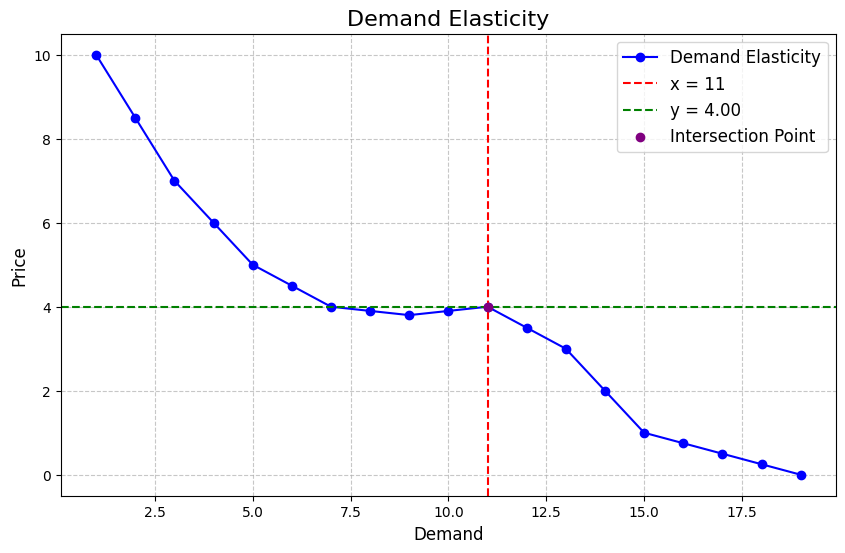

Keys in amplvar: dict_keys(['IsSelect', 'Quantity_Sold'])


In [25]:
import matplotlib.pyplot as plt

# Separate the data into X and Y values
x_values, y_values = zip(*interpolated_points)

# Find the y-coordinate
x_target = amplvar["Quantity_Sold"]["Quantity_Sold.val"].iloc[0]
if x_target in x_values:
    y_target = y_values[x_values.index(x_target)]
else:
    # Interpolate y-coordinate if x_target is not in x_values
    from scipy.interpolate import interp1d

    interpolation_function = interp1d(x_values, y_values, kind="linear")
    y_target = interpolation_function(x_target)

# Create a plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(
    x_values, y_values, marker="o", linestyle="-", color="b", label="Demand Elasticity"
)

# Add a vertical line at x = 1100
plt.axvline(x=x_target, color="r", linestyle="--", label=f"x = {x_target}")

# Add a horizontal line at the intersection point
plt.axhline(y=y_target, color="g", linestyle="--", label=f"y = {y_target:.2f}")

# Mark the intersection point
plt.scatter(
    [x_target], [y_target], color="purple", zorder=5, label="Intersection Point"
)

# Customize the plot
plt.title("Demand Elasticity", fontsize=16)
plt.xlabel("Demand", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)  # Add a grid
plt.legend(fontsize=12)  # Add a legend

# Show the plot
plt.show()
print("Keys in amplvar:", amplvar.keys())